<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Parallelizing Xarray with Dask

**ESDS dask tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)

---------
### In this tutorial, you learn:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly.
* Xarray built-in operations can transparently use dask
---------

## Introduction

### Xarray Quick Overview

<img src="https://examples.dask.org/_images/dataset-diagram-logo.png"
     width="30%"
     alt="Xarray"
/>
     
Xarray is an open-source Python library designed for working with *labelled multi-dimensional* data. By *multi-dimensional* data (also often called *N-dimensional*), we mean data that has many independent dimensions or axes (e.g. latitude, longitude, time). By labelled we mean that these axes or dimensions are associated with coordinate names (like "latitude") and coordinate labels like "30 degrees North".

Xarray provides pandas-level convenience for working with this type of data.


<img src="http://xarray.pydata.org/en/stable/_images/dataset-diagram.png"
     width="50%"
     alt="Xarray"
     style="vertical-align:middle;margin:30px 0px"/>

The dataset illustrated has two variables (`temperature` and `precipitation`) that have three dimensions. Coordinate vectors (e.g., latitude, longitude, time) that describe the data are also included.

     
#### Xarray Data Structures

Xarray has two fundamental data structures:

* `DataArray` : holds a single multi-dimensional variable and its coordinates
* `Dataset` : holds multiple DataArrays that potentially share the same coordinates


##### Xarray DataArray

A `DataArray` has four essential attributes:
* `data`: a `numpy.ndarray` holding the values.
* `dims`: dimension names for each axis (e.g., latitude, longitude, time).
* `coords`: a dict-like container of arrays (coordinates) that label each point (e.g., 1-dimensional arrays of numbers, datetime objects or strings).
* `attrs`: a dictionary to hold arbitrary metadata (attributes).

##### Xarray DataSet

A dataset is simply an object containing multiple Xarray DataArrays indexed by variable name.


Xarray integrates with Dask to support parallel computations and streaming datasets that **don’t fit into memory.** 



### Xarray can wrap many array types like Numpy and Dask.


Let's start with a random 2D NumPy array, for example this can be SST values of a domain with dimension of 300x450 grid:

In [1]:
import numpy as np 
import dask.array as da
import xarray as xr
import warnings
warnings.filterwarnings('ignore')
xr.set_options(display_expand_data=False);


In [2]:
# -- numpy array 
sst_np = np.random.rand(300,450)
type(sst_np)

numpy.ndarray

As we saw in the previous tutorial, we can convert them to a Dask Array:

In [3]:
sst_da = da.from_array( sst_np)
sst_da

dask.array<array, shape=(300, 450), dtype=float64, chunksize=(300, 450), chunktype=numpy.ndarray>

This is great and fast! BUT
* What if we want to attach coordinate values to this array?
* What if we want to add metadat (e.g. units) to this array?

In [4]:
# similarly we can convert them to xarray datarray
sst_xr = xr.DataArray(sst_da)
sst_xr

<xarray.DataArray 'array-d02ff7869631a1ec72b6d49dc449f850' (dim_0: 300,
                                                            dim_1: 450)>
dask.array<chunksize=(300, 450), meta=np.ndarray>
Dimensions without coordinates: dim_0, dim_1

A simple DataArray without dimensions or coordinates isn't much use.

In [5]:
# we can add dimension names to this:
sst_xr = xr.DataArray(sst_da,dims=['lat','lon'])

sst_xr.dims

('lat', 'lon')

We can add our coordinates with values to it :


In [6]:
# -- create some dummy values for lat and lon dimensions
lat = np.random.uniform(low=-90, high=90, size=300)
lon = np.random.uniform(low=-180, high=180, size=450)

sst_xr = xr.DataArray(sst_da,
                      dims=['lat','lon'],
                      coords={'lat': lat, 'lon':lon},
                      attrs=dict(
                        description="Sea Surface Temperature.",
                        units="degC")
                     )
sst_xr

<xarray.DataArray 'array-d02ff7869631a1ec72b6d49dc449f850' (lat: 300, lon: 450)>
dask.array<chunksize=(300, 450), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 33.24 27.27 -6.985 20.33 ... -53.58 14.62 0.09815
  * lon      (lon) float64 -141.4 -100.6 -83.93 -64.42 ... -95.97 93.24 -64.99
Attributes:
    description:  Sea Surface Temperature.
    units:        degC

Xarray data structures are a very powerful tool that allows us to use metadata to express different analysis patterns (slicing, selecting, groupby, averaging, and many other things). 

<div class="alert alert-success fade show" markdown="1">

<b>TakeAway</b> 

Xarray DataArray provides a wrapper around arrays, and uses labeled dimensions and coordinates to support metadata-aware operations (e.g. `da.sum(dim="time")` instead of `array.sum(axis=-1)`)

**Xarray can wrap dask arrays instead of numpy arrays.** 

This capability turns Xarray into an extremely useful tool for Big Data earth science.
</div>

With this introduction, let's start our tutorial on features of Xarray and Dask:

### Setup: Spinning up a cluster

In [7]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client


2023-02-05 15:50:54,690 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-vli_y1kw', purging
2023-02-05 15:50:54,691 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-iofyudur', purging
2023-02-05 15:50:54,692 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-k9c3yy3v', purging
2023-02-05 15:50:54,692 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-zq1wi1td', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/casper_16_4/proxy/36533/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/casper_16_4/proxy/36533/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41623,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/casper_16_4/proxy/36533/status,Total threads: 4
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:46373,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/casper_16_4/proxy/43955/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:46814,


-----------
## Reading data with Dask and Xarray

### Reading multiple netCDF files with `open_mfdataset`

Xarray provides a function called `open_dataset` function that allows us to load a netCDF dataset into a Python data structure. To read more about this function, please see [xarray `open_dataset` API documentation](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html). 

Xarray also provides `open_mfdataset`, which open multiple files as a single xarray dataset. Passing the argument `parallel=True` will speed up reading multiple datasets by executing these tasks in parallel using Dask Delayed under the hood. 

In this example, we are going to examine a subset  of CESM2 Large Ensemble Data Sets (LENS). We will use 2m temperature (TREFHT) for this analysis. 

To learn more about LENS dataset, please visit:
* [LENS official website](https://www.cesm.ucar.edu/community-projects/lens/data-sets)
* [LENS paper](https://www.cesm.ucar.edu/community-projects/lens/data-sets)

First, we open up multiple files using `open_mfdataset` function:

### Constructing Xarray Datasets from files

In [8]:
import os
import glob

var = 'TREFHT'

# find all LENS files for 1 ensemble
data_dir = os.path.join('/glade/campaign/cgd/cesm/CESM2-LE/timeseries/atm/proc/tseries/month_1/', var)
files = glob.glob(os.path.join(data_dir, 'b.e21.BSSP370smbb.f09_g17.LE2-1301.013*.nc'))

print("All files: [", len(files), "files]")

All files: [ 9 files]


In [9]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    # concatenate along this dimension
    concat_dim='ensemble_member',
    # concatenate files in the order provided
    combine="nested",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the netcdf4-python package to read them
    engine="netcdf4",
)
ds

CPU times: user 782 ms, sys: 141 ms, total: 923 ms
Wall time: 3.04 s


<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, lon: 288, lev: 32, ilev: 33, time: 1032,
                   ensemble_member: 9, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: ensemble_member, nbnd
Data variables: (12/27)
    zlon_bnds     (ensemble_member, zlon, nbnd) float64 dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    gw            (ensemble_member, lat) float64 dask.array<chunksize=(1, 192), meta=np.ndarray>
    hyam          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    hybm          (ensemble_member, lev) float64 dask.array<chunksize=(1, 32), meta=np.ndarray>
    P0            (ensemble_member) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (ensemble_member, ilev) float64 dask.array<chunksize=(1, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f11vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    f12vmr        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    sol_tsi       (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    nsteph        (ensemble_member, time) float64 dask.array<chunksize=(1, 1032), meta=np.ndarray>
    TREFHT        (ensemble_member, time, lat, lon) float32 dask.array<chunksize=(1, 1032, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370smbb.f09_g17.LE2-1301.013
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.BHISTsmbb.f09_g17.LE2-1301.013.cam.i.2015-01-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

Note that the "real" values are not displayed, since that would trigger actual computation.  
<div class="alert alert-success" markdown="1">
<b>Xarray automatically wraps Dask Arrays and Dask is lazy, meaning that operations are not computed until we explicitly request them, for example by calling `.compute()`. </b> 
</div>


Please see previous notebooks for more information on "lazy evaluation". 

The represntation of `TREFHT` DataArray shows details of chunks and chunk-sizes of Xarray DataArray:

In [10]:
tref = ds.TREFHT
tref

<xarray.DataArray 'TREFHT' (ensemble_member: 9, time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(1, 1032, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: ensemble_member
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

* How many chunks do we have? 
* What is the size of each chunk size?


Here we can see that we have a total of 15 chunks equal to the number of our netCDF files. In general `open_mfdataset` will chunk each netCDF file into a single Dask array. By providing the `chunks` argument, we can control the size of the resulting Dask arrays. 


<div class="alert alert-block alert-warning">

<b>WARNING:</b> When `chunks` argument is not given to `open_mfdataset`, it will return dask arrays with chunk sizes equal to each netCDF file.  
    Re-chunking the dataset after creation with ds.chunk() will lead to an ineffective use of memory and is not recommended.
</div>

In the example below, we call `open_mfdataset` to open multiple netCDF files and using the `chunks` argument to control the size of the resulting Dask arrays. 

In [11]:
#del ds
chunk_dict = {"lat": 96, "lon": 144}

In [12]:
%%time
ds = xr.open_mfdataset(
    sorted(files),
    concat_dim='time',
    combine="nested",
    parallel=True,
    engine="netcdf4",
    chunks=chunk_dict,
)
tref = ds.TREFHT
tref

CPU times: user 259 ms, sys: 21.9 ms, total: 281 ms
Wall time: 355 ms


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 96, 144), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [13]:
tref.chunks

((120, 120, 120, 120, 120, 120, 120, 120, 72), (96, 96), (144, 144))

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> The `chunks` parameter can significantly affect total performance when using Dask Arrays. `chunks` be small enough that each chunk fit in the memory, but large enough to avoid that the communication overhead. 

</div>

A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements. Here we have 120*96*144 elements in each chunk (except for the last chunk).   
With large arrays (10+ GB), the cost of queueing up Dask operations can be noticeable, and you may need even larger chunksizes. See the [dask.array best practices](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size)

For complex scenarios, you can access each file individually by utilizing the `open_dataset` function with the specified `chunk`s and then combine the outputs into a single dataset later.

### Xarray data structures are Dask collections.

This means you can call the following Dask-related functions on Xarray Data Arrays and Datasets:

* `dask.visualize()`
* `dask.compute()`
* `dask.persist()`

For more information abour Dask Arrays, please see [the first tutorial](https://ncar.github.io/dask-tutorial/notebooks/01-dask-array.html).

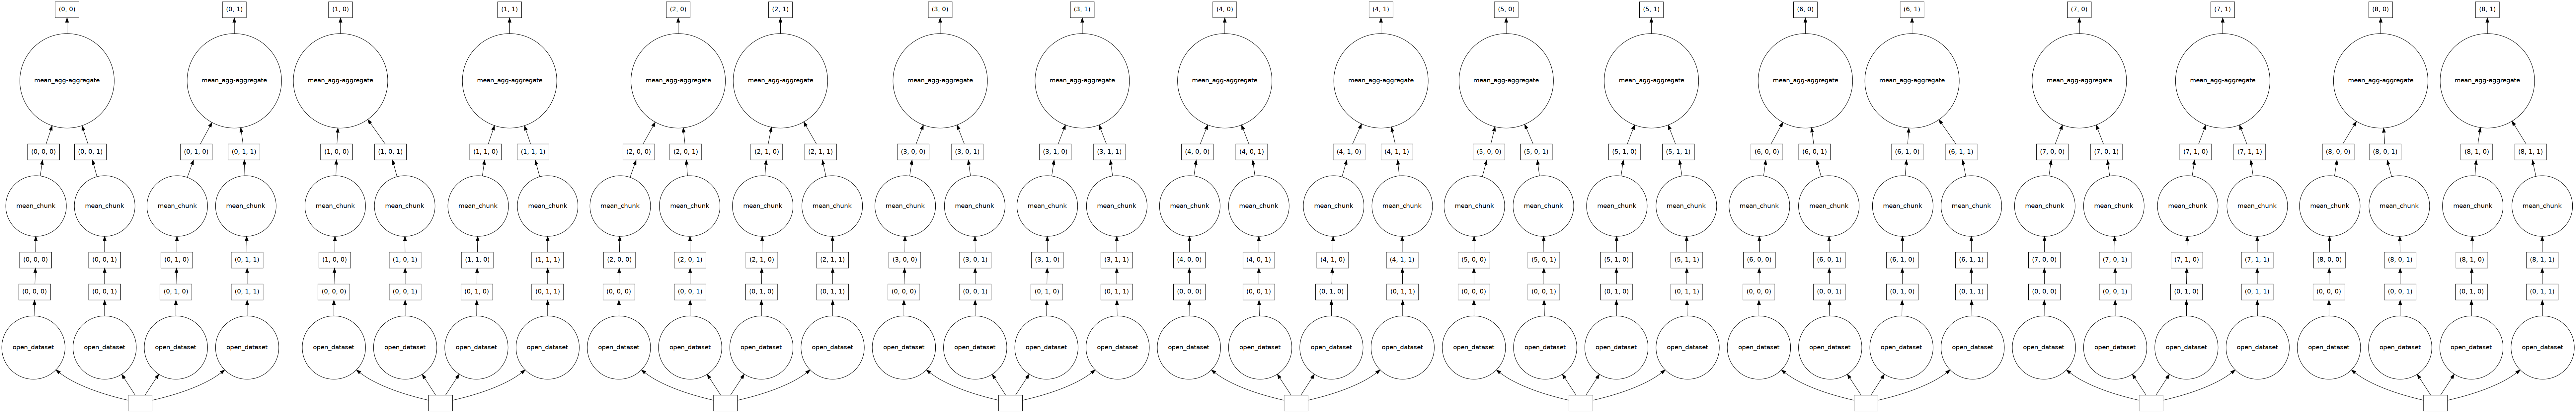

In [14]:
import dask
tref_mean = tref.mean(axis=-1)
dask.visualize(tref_mean)

If we check Dask Task Graph for `tref_mean`, we can see all the steps required for calculating it (from openning the netcdf file to calculating mean and aggreagting it). 

Getting concrete values
At some point, you will want to actually do the calculations and recieve concreate values from Dask.

There are two ways to compute values on dask arrays.

1.`compute()` returns an xarray object just like a dask array.

2.`load()` replaces the dask array in the xarray object with a numpy array. equivalent to `ds = ds.compute()`.

So the difference is that `.load()` operates inplace and `.compute()` returns a new xarray object.

Tip: There is another option available  third option : “persisting”. `.persist()` loads the values into distributed RAM.
The values are computed but remain distributed across workers. So `ds.air.persist()` still returns a dask array. This is useful if you will be repeatedly using a dataset for computation but it is too large to load into local memory. 

To summarize, `persist` turns a lazy Dask collection into a Dask collection with the same metadata, but now with the results fully computed or actively computing in the background.


See the [Dask user guide](https://docs.dask.org/en/stable/generated/dask.dataframe.Series.persist.html) if you `.persist()`.

## How to access underlying data in an Xarray object?

There are two basic ways to extract values from an Xarray object:

1. Using `.data` will return a Dask array. For example:

In [15]:
tref.data

dask.array<concatenate, shape=(1032, 192, 288), dtype=float32, chunksize=(120, 96, 144), chunktype=numpy.ndarray>

**This means that for Dask-backed Xarray object, we can access the values using `.compute`**

In [16]:
tref.data.compute()

array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

2. We can also use `.values` to see the "real" values of Xarray object. Another option is using `.to_numpy`. Both of these option return the values of underlying Dask object in a numpy array. 

In [17]:
%%time
tref.to_numpy()

CPU times: user 187 ms, sys: 387 ms, total: 575 ms
Wall time: 1.5 s


array([[[248.39987, 248.39989, 248.39992, ..., 248.39989, 248.39989,
         248.39989],
        [248.95004, 248.9094 , 248.75017, ..., 248.98384, 248.97466,
         248.9626 ],
        [249.20784, 249.17082, 249.15718, ..., 249.42188, 249.37703,
         249.31105],
        ...,
        [251.5821 , 251.6182 , 251.65166, ..., 251.48357, 251.51555,
         251.54646],
        [251.34143, 251.35114, 251.36166, ..., 251.30699, 251.32008,
         251.3312 ],
        [251.35237, 251.35286, 251.35332, ..., 251.35059, 251.35123,
         251.35182]],

       [[237.44759, 237.44759, 237.44759, ..., 237.44759, 237.44759,
         237.44759],
        [238.10292, 238.05934, 237.8917 , ..., 238.16042, 238.14326,
         238.12119],
        [238.86865, 238.82155, 238.79092, ..., 239.1196 , 239.04976,
         238.96754],
        ...,
        [246.23404, 246.25865, 246.28221, ..., 246.15912, 246.18312,
         246.20715],
        [246.70511, 246.7112 , 246.71793, ..., 246.68782, 246.69476,
   

## Computation

All built-in Xarray methods (`.mean`, `.max`, `.rolling`, `.groupby` etc.) support dask arrays.

Now, let's do some computations on this Xarray dataset. 

### Single Point Calculations

To start out, let's do the calculations on a single point first. First, we extract the time series data at a grid point and save it to a variable. Here we select the closest point using `.sel` and load the data. 

In [18]:
tref_boulder = tref.sel(lat=40.0150, lon=-105.2705, method='nearest').load()


In [19]:
# -- take annual average
tb = tref_boulder.resample(time='AS').mean()
tb

<xarray.DataArray 'TREFHT' (time: 87)>
291.8 290.3 290.3 290.1 290.7 291.2 ... 294.3 293.5 293.5 293.4 293.9 289.8
Coordinates:
    lat      float64 40.05
    lon      float64 0.0
  * time     (time) object 2015-01-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

We can either see the values of our DataArray using `.compute()` or `.data` or by plotting it:


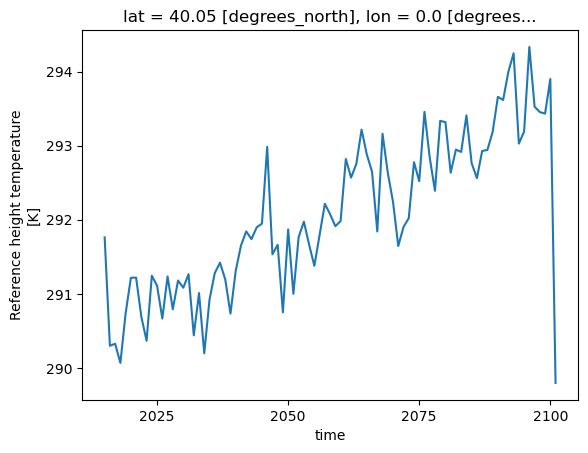

In [20]:
tb.plot()

### Calculations over all grids

In [21]:
# change the unit from Kelvin to degree Celsius 
tref_c = tref- 273.15
tref_c

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 96, 144), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [22]:
# Until we explicitly call load() or compute(), Dask actually didn't do any real calculation
# We are doing the calculations below parallelly. However not much benefit from parallel computing since it's not a big problem
%time tref_c=tref_c.load()

CPU times: user 218 ms, sys: 406 ms, total: 624 ms
Wall time: 1.66 s


In [23]:
%%time

# Compute monthly anomaly

# -- 1. calculate monthly average
tref_grouped = tref.groupby('time.month')
tmean = tref_grouped.mean(dim='time')

#-- 2. calculate monthly anomaly
tos_anom = tref_grouped - tmean
tos_anom

CPU times: user 189 ms, sys: 23.5 ms, total: 212 ms
Wall time: 209 ms


<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(1, 96, 144), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 3 4 5 6 7 8 9 10 11 12 1

Dask actually constructs a graph of the required computation.

Call `.compute()` or `.load()` when you want your result as a xarray.DataArray to access underlying dataset:
* `.compute() ` works similarly here as Dask DataArray. It basically triggers the computations across different chunks of the DataArray. 
* `.load()` replaces the dask array in the Xarray object with a numpy array. 

In [24]:
%%time
computed_anom = tos_anom.load()
type(computed_anom)

CPU times: user 7.38 s, sys: 832 ms, total: 8.21 s
Wall time: 10.6 s


xarray.core.dataarray.DataArray

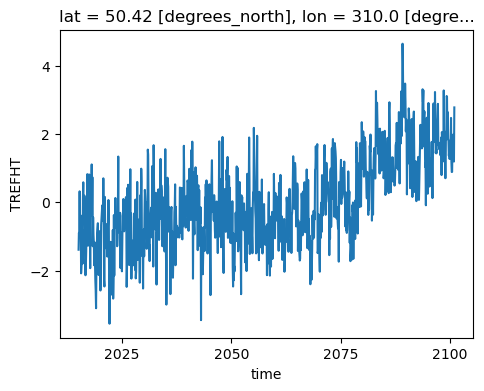

In [25]:
tos_anom.sel(lon=310, lat=50, method='nearest').plot( size=4)

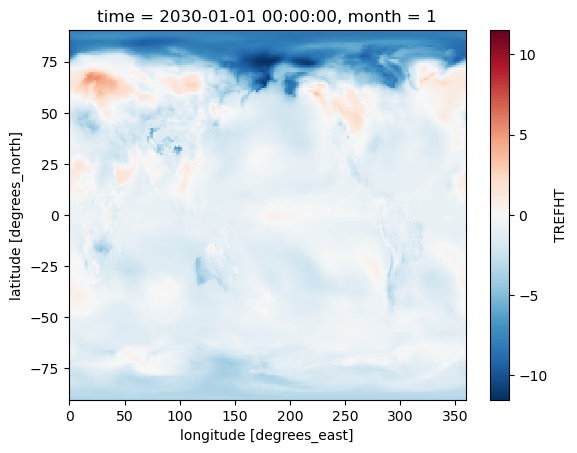

In [27]:
tos_anom.sel(time='2030-01-01').plot()

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> Using Xarray plotting functionality automatically triggers computations on the Dask Array, similar to `.compute()`.

</div>

### Supplementary Material: Rechunking
* rechunking will be covered in-depth in the next tutorial. 

We can always rechunk an Xarray DataArray. For example, what is the chunk size of `tref`?

In [28]:
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(120, 96, 144), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

Is this a good chunk size?

In [29]:
chunk_dict = {"time":90, "lat": 192, "lon": 288}
tref = tref.chunk(chunk_dict)
tref

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(90, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

We can do more complex calculations too:

In [30]:
rolling_mean = tref.rolling(time=5).mean()
rolling_mean  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(94, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [31]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

<xarray.DataArray 'TREFHT' (time: 1032)>
dask.array<chunksize=(94,), meta=np.ndarray>
Coordinates:
    lat      float64 -71.15
    lon      float64 1.25
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [32]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
nan nan nan nan nan nan nan nan ... 273.4 273.4 273.4 273.4 273.4 273.4 273.4
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

### Supplementary Material: Advanced workflows and automatic parallelization using `apply_ufunc`
Most of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by Xarray to work with Dask, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s `apply_ufunc()` function. `xr.apply_ufunc()` can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays, but we want to apply it on our Xarray DataArray. 

`xr.apply_ufunc()` give users capability to run custom-written functions such as parameter calculations in a parallel way. See the [Xarray tutorial material on apply_ufunc](https://tutorial.xarray.dev/advanced/apply_ufunc/apply_ufunc.html) for more.

In the example below, we calculate the saturation vapor pressure by using `apply_ufunc()` to apply this function to our Dask Array chunk by chunk. 

In [33]:
import numpy as np
# return saturation vapor pressure
# using Clausius-Clapeyron equation
def sat_p(t):
    return 0.611*np.exp(17.67*(t-273.15)*((t-29.65)**(-1)))

In [34]:
es=xr.apply_ufunc(sat_p,tref,dask="parallelized",output_dtypes=[float])


In [35]:
es

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
dask.array<chunksize=(90, 192, 288), meta=np.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

In [36]:
es.compute()

<xarray.DataArray 'TREFHT' (time: 1032, lat: 192, lon: 288)>
0.08275 0.08275 0.08275 0.08275 0.08275 ... 0.5323 0.5323 0.5323 0.5323 0.5323
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00

The data used for this tutorial is from one ensemble member. What if we want to use multiple ensemble members? So far, we only run on one machine, what if we run an HPC cluster? We will go over this in the next tutorial.

### Dask + Xarray Good Practices

<div class="alert alert-success fade show" markdown="1">

<b>Summary of Dask + Xarray Good Practices</b> 


The good practices regarding Dask + Xarray is the same as the good practices for Dask only.

* Similar to Dask DataFrames, it is more efficient to first do spatial and temporal indexing (e.g. .sel() or .isel()) and filter the dataset early in the pipeline, especially before calling resample() or groupby(). 

* Chunk sizes should be small enough to fit into the memory at once but large enough to avoid the additional communication overhead. Good chunk size ~100 MB. 

* It is always better to chunk along the `time` dimension. 

* Avoid too many tasks since each task will introduce 1ms of overhead. 

* When possible, use `xr.apply_ufunc` to apply an unvectorized function to the Xarray object. 

</div>



### Close you local Dask Cluster
It is always a good practice to close the Dask cluster you created.

In [37]:
client.shutdown()

## Summary

In this notebook, we have learned about:

* Using Dask with Xarray
* Read/write netCDF files with Dask
* Dask backed Xarray objects and operations
* Extract Dask arrays from Xarray objects and use Dask array directly..
* Customized workflows using `apply_ufunc`

## Resources and references

* Reference
    *  [Dask Array Docs](https://docs.dask.org/en/stable/array.html)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
    *  [Xarray + Dask docs](https://docs.xarray.dev/en/stable/user-guide/dask.html), particularly the [optimization tips](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)
    * [Xarray Tutorial material](https://tutorial.xarray.dev/intro.html)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests